In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

***Load The Dataset***

In [52]:
# LOAD THE DATASET :
df = pd.read_csv("../Data/raw/subset_data.csv")
# DISPLAY THE FIRST 5 ROWS :
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


***Dataset Overview***

In [5]:
# SHAPE OF THE DATASET :
print(f"Shape of the dataset : {df.shape}")

Shape of the dataset : (50000, 9)


In [7]:
# COLUMNS INFORMATIONS :
print("Column Count,Names and The data type (dtype) of each column :")
df.info()

Column Count,Names and The data type (dtype) of each column :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    50000 non-null  object 
 1   user_id      50000 non-null  object 
 2   business_id  50000 non-null  object 
 3   stars        50000 non-null  float64
 4   useful       50000 non-null  int64  
 5   funny        50000 non-null  int64  
 6   cool         50000 non-null  int64  
 7   text         50000 non-null  object 
 8   date         50000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


In [9]:
# STATISTICS OF NUMERICAL COLUMNS :
df.describe()

,stars,useful,funny,cool
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,3.848000,0.889540,0.250440,0.345060
std,1.350308,1.864481,0.941455,1.072388
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,91.000000,38.000000,49.000000


***Handling Duplicated Values***

In [11]:
# CHECKING FOR DUPLICATED VALUES :
df_duplicates = df.duplicated()
print(f"number of duplicated rows : {df_duplicates.sum()}")

number of duplicated rows : 0


***Handling Missing Values***

In [13]:
# CHECKING FOR MISSING VALUES :
df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

***Target Distribution***

In [54]:
# ASSINING EACH STAR VALUE A SENTIMENT :
df.loc[df['stars'] == 3, 'sentiment'] = 'neutral' 
df.loc[df['stars'] < 3, 'sentiment'] = 'negative' 
df.loc[df['stars'] > 3, 'sentiment'] = 'positive'

sentiment
positive    34941
negative     9382
neutral      5677
Name: count, dtype: int64


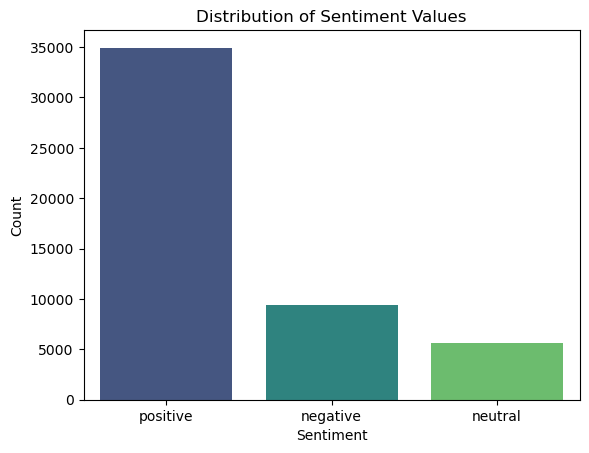

In [48]:
# VISUALIZING THE DISTRIBUTION OF SENTIMENT VALUES :
sentiment = df_reviews['sentiment'].value_counts()

# Convert to a DataFrame for sns.barplot compatibility
sentiment_counts_df = sentiment.reset_index()
sentiment_counts_df.columns = ['sentiment', 'count']

# Create a bar plot for the distribution of sentiment values
sns.barplot(data=sentiment_counts_df, x='sentiment', y='count',hue='sentiment', palette="viridis",legend=False)

# Adding title and labels
plt.title('Distribution of Sentiment Values')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

In [56]:
# NEW DATASET :
df_reviews = df[['sentiment','text']]
# DISPLAY THE FIRST 5 ROWS
df_reviews.head()

,sentiment,text
0,neutral,"If you decide to eat here, just be aware it is..."
1,positive,I've taken a lot of spin classes over the year...
2,neutral,Family diner. Had the buffet. Eclectic assortm...
3,positive,"Wow! Yummy, different, delicious. Our favo..."
4,positive,Cute interior and owner (?) gave us tour of up...


# Text Preprocessing 

***Convert Text to Lowercase***

In [60]:
# PREPERING TEXT :
df_reviews.loc[:,'text'] = df_reviews["text"].str.lower()
df_reviews.head()

,sentiment,text
0,neutral,"if you decide to eat here, just be aware it is..."
1,positive,i've taken a lot of spin classes over the year...
2,neutral,family diner. had the buffet. eclectic assortm...
3,positive,"wow! yummy, different, delicious. our favo..."
4,positive,cute interior and owner (?) gave us tour of up...


***Remove Punctuations From Text***

In [63]:
# Removal of Punctuations !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
import string

PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_reviews.loc[:,"text"] = df_reviews["text"].apply(lambda text: remove_punctuation(text))
df_reviews.head()

,sentiment,text
0,neutral,if you decide to eat here just be aware it is ...
1,positive,ive taken a lot of spin classes over the years...
2,neutral,family diner had the buffet eclectic assortmen...
3,positive,wow yummy different delicious our favorite...
4,positive,cute interior and owner gave us tour of upcom...


***Remove Numbers From Text***

In [37]:
# Removal of Numbers
df_reviews.loc[:,'text'] = df_reviews['text'].str.replace(r'\d+', '', regex=True) 
df_reviews.head()

,sentiment,text
0,neutral,if you decide to eat here just be aware it is ...
1,positive,ive taken a lot of spin classes over the years...
2,neutral,family diner had the buffet eclectic assortmen...
3,positive,wow yummy different delicious our favorite...
4,positive,cute interior and owner gave us tour of upcom...


***replacing \n and \r***

In [39]:
# Replace Newline and Carriage Return Characters
df_reviews.loc[:,'text'] = df_reviews['text'].str.replace('\n',' ', regex=True).str.replace('\r','', regex=True)
df_reviews.head()

,sentiment,text
0,neutral,if you decide to eat here just be aware it is ...
1,positive,ive taken a lot of spin classes over the years...
2,neutral,family diner had the buffet eclectic assortmen...
3,positive,wow yummy different delicious our favorite...
4,positive,cute interior and owner gave us tour of upcom...


***Download tokenizer models And WordNet database***

In [86]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CHAKOR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CHAKOR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

***Remove StopWords From Text***

In [75]:
# Removal of stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_reviews.loc[:, "text"] = df_reviews["text"].apply(lambda text: remove_stopwords(text))
df_reviews.head()

,sentiment,text
0,neutral,decide eat aware going take 2 hours beginning ...
1,positive,ive taken lot spin classes years nothing compa...
2,neutral,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave us tour upcoming pati...


***Text Lemmatization*** 

In [79]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_reviews.loc[:,'text'] = df_reviews['text'].apply(lemmatize_text)
df_reviews.head()

,sentiment,text
0,neutral,decide eat aware going take 2 hour beginning e...
1,positive,ive taken lot spin class year nothing compare ...
2,neutral,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave u tour upcoming patio...


***Remove Extra Space From Text***

In [42]:
# Removing Extra space
df_reviews.loc[:,'text'] = df_reviews['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df_reviews.head()

,sentiment,text
0,neutral,decide eat aware going take hour beginning end...
1,positive,ive taken lot spin class year nothing compare ...
2,neutral,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave u tour upcoming patio...


***Text Tokenization***

In [88]:
# Tokenization
df_reviews.loc[:,'tokens'] = df_reviews['text'].apply(word_tokenize)
df_reviews.head()

,sentiment,text,tokens
0,neutral,decide eat aware going take 2 hour beginning e...,"[decide, eat, aware, going, take, 2, hour, beg..."
1,positive,ive taken lot spin class year nothing compare ...,"[ive, taken, lot, spin, class, year, nothing, ..."
2,neutral,family diner buffet eclectic assortment large ...,"[family, diner, buffet, eclectic, assortment, ..."
3,positive,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l..."
4,positive,cute interior owner gave u tour upcoming patio...,"[cute, interior, owner, gave, u, tour, upcomin..."


***Relationship Between Sentiment and Length of Text***

In [90]:
# CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
df_reviews.loc[:, 'length'] = df_reviews['text'].apply(len)
df_reviews.head()

,sentiment,text,tokens,length
0,neutral,decide eat aware going take 2 hour beginning e...,"[decide, eat, aware, going, take, 2, hour, beg...",277
1,positive,ive taken lot spin class year nothing compare ...,"[ive, taken, lot, spin, class, year, nothing, ...",540
2,neutral,family diner buffet eclectic assortment large ...,"[family, diner, buffet, eclectic, assortment, ...",260
3,positive,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l...",153
4,positive,cute interior owner gave u tour upcoming patio...,"[cute, interior, owner, gave, u, tour, upcomin...",380


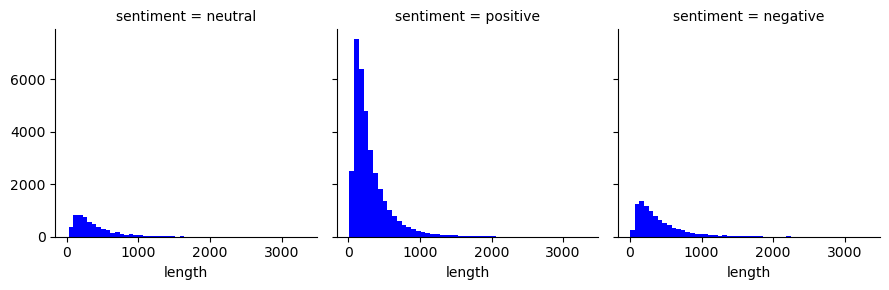

In [103]:
# COMPARING TEXT LENGTH TO SENTIMENT
graph = sns.FacetGrid(data=df_reviews,col='sentiment')
graph.map(plt.hist,'length',bins=50,color='blue')

# Feature Encoding

***Feature Encoding For Text Using The TF-IDF(TfidfVectorizer)***

In [98]:
# Combine token lists back into a single string for each review
df_reviews.loc[:,'processed_text'] = df_reviews['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed text to get the TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(df_reviews['processed_text'])
print(f"the shape of the TF-IDF matrix :{X_tfidf.shape}")

the shape of the TF-IDF matrix :(50000, 62622)


***Feature Encoding For Sentiment Using OrdinalEncoder***

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Install required libraries
!pip install -q transformers datasets seaborn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Check GPU availability
print("GPU Available:", torch.cuda.is_available())

# Load the preprocessed dataset
# Modify the path if needed
df_reviews = pd.read_csv("/content/drive/MyDrive/data/processed/df_reviews.csv")
print(df_reviews.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df_reviews['text'],
    df_reviews['sentiment'],
    test_size=0.2,
    random_state=42
)

# Map sentiment labels to numeric values
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_numeric = y_train.map(label_map).tolist()
y_test_numeric = y_test.map(label_map).tolist()

# Save y_test_numeric to a CSV file
pd.DataFrame(y_test_numeric, columns=['sentiment']).to_csv("/content/drive/MyDrive/data/processed/y_test_numeric.csv", index=False)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenization for RoBERTa
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings_roberta = tokenizer_roberta(
    X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt"
)
test_encodings_roberta = tokenizer_roberta(
    X_test.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt"
)

# Tokenization for XLNet
tokenizer_xlnet = XLNetTokenizer.from_pretrained('xlnet-base-cased')
train_encodings_xlnet = tokenizer_xlnet(
    X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt"
)
test_encodings_xlnet = tokenizer_xlnet(
    X_test.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt"
)

# Create datasets
train_dataset_roberta = CustomDataset(train_encodings_roberta, y_train_numeric)
test_dataset_roberta = CustomDataset(test_encodings_roberta, y_test_numeric)
train_dataset_xlnet = CustomDataset(train_encodings_xlnet, y_train_numeric)
test_dataset_xlnet = CustomDataset(test_encodings_xlnet, y_test_numeric)

# Define models
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model_xlnet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)

# Define compute_metrics function for more detailed evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments with early stopping and regularization
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/models',
    num_train_epochs=20,  # Increase the number of epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.05,  # Increase the weight decay for more regularization
    logging_dir='/content/drive/MyDrive/logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=2,
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)  # Increase the patience

# Train and evaluate using RoBERTa
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args,
    train_dataset=train_dataset_roberta,
    eval_dataset=test_dataset_roberta,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)
trainer_roberta.train()
predictions_roberta = trainer_roberta.predict(test_dataset_roberta)
y_pred_roberta = np.argmax(predictions_roberta.predictions, axis=1)

# Train and evaluate using XLNet
trainer_xlnet = Trainer(
    model=model_xlnet,
    args=training_args,
    train_dataset=train_dataset_xlnet,
    eval_dataset=test_dataset_xlnet,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)
trainer_xlnet.train()
predictions_xlnet = trainer_xlnet.predict(test_dataset_xlnet)
y_pred_xlnet = np.argmax(predictions_xlnet.predictions, axis=1)

# Plotting functions (same as before)
def plot_training_and_validation_loss(trainer, model_name):
    training_losses = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]
    validation_losses = [entry["eval_loss"] for entry in trainer.state.log_history if "eval_loss" in entry]
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, label='Training Loss', color='blue')
    plt.plot(epochs, validation_losses, label='Validation Loss', color='orange')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f'/content/drive/MyDrive/models/{model_name.lower()}_loss_plot.png')
    plt.close()

def plot_evaluation_metrics(y_true, y_pred, model_name):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')
    }
    metric_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])

    plt.figure(figsize=(10, 6))
    sns.barplot(data=metric_df, x='Metric', y='Score')
    plt.title(f'{model_name} Evaluation Metrics')
    plt.ylim(0, 1)
    plt.savefig(f'/content/drive/MyDrive/models/{model_name.lower()}_metrics_plot.png')
    plt.close()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'/content/drive/MyDrive/models/{model_name.lower()}_confusion_matrix.png')
    plt.close()

# Plot losses and metrics
plot_training_and_validation_loss(trainer_roberta, "RoBERTa")
plot_training_and_validation_loss(trainer_xlnet, "XLNet")
plot_evaluation_metrics(y_test_numeric, y_pred_roberta, "RoBERTa")
plot_evaluation_metrics(y_test_numeric, y_pred_xlnet, "XLNet")
plot_confusion_matrix(y_test_numeric, y_pred_roberta, "RoBERTa")
plot_confusion_matrix(y_test_numeric, y_pred_xlnet, "XLNet")

# Save the trained models
trainer_roberta.save_model('/content/drive/MyDrive/models/roberta_model')
trainer_xlnet.save_model('/content/drive/MyDrive/models/xlnet_model')

# Generate a final report
report = f"""
Training Report
================

Models:
- RoBERTa
- XLNet

Training Epochs: 20

Evaluation Metrics:

RoBERTa:
- Accuracy: {accuracy_score(y_test_numeric, y_pred_roberta)}
- Precision: {precision_score(y_test_numeric, y_pred_roberta, average='weighted')}
- Recall: {recall_score(y_test_numeric, y_pred_roberta, average='weighted')}
- F1 Score: {f1_score(y_test_numeric, y_pred_roberta, average='weighted')}

XLNet:
- Accuracy: {accuracy_score(y_test_numeric, y_pred_xlnet)}
- Precision: {precision_score(y_test_numeric, y_pred_xlnet, average='weighted')}
- Recall: {recall_score(y_test_numeric, y_pred_xlnet, average='weighted')}
- F1 Score: {f1_score(y_test_numeric, y_pred_xlnet, average='weighted')}

Confusion Matrices:
- RoBERTa: {confusion_matrix(y_test_numeric, y_pred_roberta)}
- XLNet: {confusion_matrix(y_test_numeric, y_pred_xlnet)}

Models saved at:
- RoBERTa: /content/drive/MyDrive/models/roberta_model
- XLNet: /content/drive/MyDrive/models/xlnet_model
"""

print(report)

# Save the report to a file
with open('/content/drive/MyDrive/models/training_report.txt', 'w') as f:
    f.write(report)

the shape of target :(50000,)


# Data splitting

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)